This script is used to conduct analysis for the manuscript, Climate Elasticity Assessment on Groundwater Recharge to the Edwards Balcones Fault Zone Aquifer, USA

Abstract: The impacts of climate change pose potential threats to available water re-sources, particularly in relation to predicting future groundwater recharge. This study pre-sents a comprehensive analysis of the characteristics of precipitation, temperature, and groundwater recharge in the recharge zone of the nine basins of the Edwards Balcones Fault Zone Aquifer, which is one of the major groundwater systems in the United States and serves as primary water sources for approximately 1.7 million people in south-central Tex-as. Datasets of monthly precipitation and average temperature (1895-2019) and groundwater recharge (1934-2019) are used to examine the decadal variability in precipitation, tempera-ture, and groundwater recharge on the annual scale a normalized 20-year moving average of variance. Climate elasticity (precipitation and potential evapotranspiration) of groundwater recharge is estimated to evaluate impacts of climate change on groundwater recharge. The results of this study show that regional precipitation and temperature variability exhibit de-cadal cyclic patterns. Elasticity analysis of groundwater recharge indicates that a 1% change in precipitation may result in 2% [0.15% 2.8%] change and a 1% change in PET may lead to -3.3% [-8.9% 4%] change in groundwater recharge in the region. This study suggests that climate elasticity of groundwater recharge can provide an alternative means for evaluating impacts of climate on groundwater recharge.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
import os, glob

In [3]:
import statsmodels 
import statsmodels.api as sm

! python -m pip install --upgrade pip

In [4]:
import seaborn as sns

In [5]:
from matplotlib.patches import Rectangle
from matplotlib.colors import ListedColormap

In [6]:
from pyeto import thornthwaite, monthly_mean_daylight_hours, deg2rad

In [7]:
import warnings
warnings.filterwarnings('ignore')

# Load the following data


1) PRISM data precipitation monthly from 1985 through 2019-12-31 at the three zones

2) Prism data tmean, tmin, tmax, monthly from 1985 through 2019-12-31 at the three zones

3) USGS groundwater recharge estimates from 1934 through 2019-12-31 at the recharge zone



In [8]:
pwd=os.getcwd()
print(pwd)
pathoutput=os.path.join(pwd,'results')
if not os.path.exists(pathoutput):
    os.makedirs(pathoutput)

E:\projects\USGSR_PRISM data analysis\finalRun\dataUpload


## Load the USGS groundwater recharge

In [9]:
def obtainUSGSrecharge(usgsRfile):
    #usgsRfile is the excel file where USGS recharge is stored
    xl = pd.ExcelFile(usgsRfile)
    glst=[]
    
    for name in xl.sheet_names:
        if 'Readme' not in name:
            df = pd.read_excel(xl, name,usecols='A:M', skiprows=4,nrows=87)
            lst=[]
            
            for idx,row in df.iterrows():
                if idx<len(df)-1:
                    for j in range(1,13):
                        lst.append(row[j])
            glst.append(lst)
    usgsR=pd.DataFrame(glst).T        
    
    
    #clname=xl.sheet_names
    
    
    #clname.remove('Readme')
    
    
    date = pd.date_range(start='1/1/1934', end='12/31/2019', freq='M')
    #date=date.to_period('M')
    
    usgsR['date']=date
    usgsR.set_index("date", inplace = True) 
    #usgsR.columns = clname
    usgsR.columns=['Nueces','Frio and Dry Frio','Sabinal','Between Sabinal and Medina','Medina','Between Medina and Cibolo', 'Cibolo','Blanco']
    usgsR.head()
    usgsR['Guadalupe']=0   
    usgsR=usgsR[['Nueces','Frio and Dry Frio','Sabinal','Between Sabinal and Medina','Medina','Between Medina and Cibolo', 'Cibolo','Guadalupe','Blanco']]
    
    return usgsR    


In [10]:
usgsrfile=r'.\recharge\USGS Monthly Recharge by basin 1934-2019revised.xlsx'
usgsR=obtainUSGSrecharge(usgsrfile)

In [11]:
##['Nueces','Frio', 'Sabinal', 'SabMed','Medina',  'MedCib', 'Cibolo','Guad','Blanco']
areaR=[293+1477,139.3+475.7,36.8+206.5,86.4+198.6,95.2+683.7,110.8+158.8,126.2+237.5,44.9+1467.4,124.0+377.5]   # squure miles
areaR=[area*640.0 for area in areaR]  # square miles to arce

In [12]:
usgsR.head()

,Nueces,Frio and Dry Frio,Sabinal,Between Sabinal and Medina,Medina,Between Medina and Cibolo,Cibolo,Guadalupe,Blanco
date,,,,,,,,,
1934-01-31,970.0,3365.0,1125.0,2228.0,3900.0,2700.0,2547.0,0,1694.0
1934-02-28,820.0,2714.0,750.0,1782.0,3800.0,2100.0,3438.0,0,0.0
1934-03-31,1300.0,2823.0,750.0,2525.0,3900.0,3000.0,6495.0,0,1059.0
1934-04-30,1790.0,5102.0,938.0,5346.0,3900.0,5400.0,7514.0,0,7835.0
1934-05-31,2220.0,5537.0,3375.0,3416.0,3900.0,2400.0,2547.0,0,900.0


In [13]:
usgsR.index=usgsR.index.to_period('M')
usgsR.columns=['Nueces','Frio', 'Sabinal', 'SabMed','Medina', 'MedCib', 'Cibolo','Guad','Blanco']
usgsR=usgsR/areaR*12*25.4  # convert to inches then to mm
usgsR_monthly=usgsR.stack()
usgsR_monthly=usgsR_monthly.reset_index()
usgsR_monthly=usgsR_monthly.set_index('date')
usgsR_monthly.columns=['basin','value']
usgsR_monthly.loc[:,'zone']='Recharge'
usgsR_monthly.loc[:,'variable']='groundwater recharge'


In [14]:
usgsR_yearly=usgsR.resample('Y').sum()
usgsR_yearly=usgsR_yearly.stack()
usgsR_yearly=usgsR_yearly.reset_index()
usgsR_yearly=usgsR_yearly.set_index('date')
usgsR_yearly.columns=['basin','value']
usgsR_yearly.loc[:,'zone']='Recharge'
usgsR_yearly.loc[:,'variable']='groundwater recharge'

usgsR_yearly.head()

,basin,value,zone,variable
date,,,,
1934,Nueces,2.313983,Recharge,groundwater recharge
1934,Frio,21.606262,Recharge,groundwater recharge
1934,Sabinal,14.682907,Recharge,groundwater recharge
1934,SabMed,33.257289,Recharge,groundwater recharge
1934,Medina,28.431923,Recharge,groundwater recharge


In [15]:
usgsR.resample('Y').sum().loc[:,'Nueces'].sort_values().tail(10)

date
2016     74.175716
2001     80.042288
1987     83.009299
1991     87.488739
2015     92.509282
2018     96.750631
1935    110.670275
2007    126.863274
1990    128.962311
2004    129.676249
Freq: A-DEC, Name: Nueces, dtype: float64

In [16]:
usgsR_yearly.groupby('basin').describe()

value                                                           \
        count        mean         std       min        25%         50%   
basin                                                                    
Blanco   86.0   45.060222   35.744186  7.787139  21.082253   35.322746   
Cibolo   86.0  144.251895  124.329728  2.880808  44.098301  103.056991   
Frio     86.0  107.268834   88.949534  3.252439  44.809898   89.726274   
Guad     86.0    0.000000    0.000000  0.000000   0.000000    0.000000   
MedCib   86.0  122.255606  114.789319  0.787773  35.905558   86.098616   
Medina   86.0   37.884290   14.665166  3.882639  27.442767   37.559182   
Nueces   86.0   35.023803   29.483894  2.313983  15.753985   27.482755   
SabMed   86.0  183.096846  180.890233  3.352093  46.455263  127.420270   
Sabinal  86.0   79.683870   76.749043  1.068575  32.010342   61.109941   

                                 
                75%         max  
basin                            
Blanco    56.440373  217.412161  
Cibolo   208.073258  586.332235  
Frio     142.644232  454.462530  
Guad       0.000000    0.000000  
MedCib   156.975250  513.415518  
Medina    49.877848   63.589678  
Nueces    43.636608  129.676249  
SabMed   264.883566  946.011303  
Sabinal  109.820353  438.177404

## Load the PRISM data

In [17]:
var='ppt'
outputpath=os.path.join(pwd,'Prism_basinzones')
outputfl=os.path.join(outputpath, 'finalbasin_'+var+'mm.csv')
prec=pd.read_csv(outputfl,index_col='date',parse_dates=True)
cols=[col for col in prec.columns if 'Artesian' not in col]
prismprec=prec[cols]
prismprec.index=prismprec.index.to_period('M')
cols=[]
for col in prismprec:
    colnm=col.split(' ')[0]
    if 'Contributing' in colnm:
        colfnm=colnm[:-12]+' '+'Contributing'
    else:
        colfnm=colnm[:-8]+' '+'Recharge'        
    cols.append(colfnm)  
prismprec.columns=cols    
#prismprec.head()
#prismprec.plot(figsize=(12,8))

In [18]:
var='tmean'
outputpath=os.path.join(pwd,'Prism_basinzones')
outputfl=os.path.join(outputpath, 'finalbasin_'+var+'oC.csv')
df=pd.read_csv(outputfl,index_col='date',parse_dates=True)
cols=[col for col in df.columns if 'Artesian' not in col]
prismtmean=df[cols]
prismtmean.index=prismtmean.index.to_period('M')
cols=[]
for col in prismtmean:
    colnm=col.split(' ')[0]
    if 'Contributing' in colnm:
        colfnm=colnm[:-12]+' '+'Contributing'
    else:
        colfnm=colnm[:-8]+' '+'Recharge'        
    cols.append(colfnm)  
prismtmean.columns=cols    
#prismtmean.head()
#prismtmean.plot(figsize=(12,8))

In [19]:
var='tmax'
outputpath=os.path.join(pwd,'Prism_basinzones')
outputfl=os.path.join(outputpath, 'finalbasin_'+var+'oC.csv')
df=pd.read_csv(outputfl,index_col='date',parse_dates=True)
cols=[col for col in df.columns if 'Artesian' not in col]
prismtmax=df[cols]
prismtmax.index=prismtmax.index.to_period('M')
cols=[]
for col in prismtmax:
    colnm=col.split(' ')[0]
    if 'Contributing' in colnm:
        colfnm=colnm[:-12]+' '+'Contributing'
    else:
        colfnm=colnm[:-8]+' '+'Recharge'        
    cols.append(colfnm)  
prismtmax.columns=cols    
#prismtmax.head()
#prismtmax.plot(figsize=(12,8))


In [20]:
var='tmin'
outputpath=os.path.join(pwd,'Prism_basinzones')
outputfl=os.path.join(outputpath, 'finalbasin_'+var+'oC.csv')
df=pd.read_csv(outputfl,index_col='date',parse_dates=True)
cols=[col for col in df.columns if 'Artesian' not in col]
prismtmin=df[cols]
prismtmin.index=prismtmin.index.to_period('M')
cols=[]
for col in prismtmin:
    colnm=col.split(' ')[0]
    if 'Contributing' in colnm:
        colfnm=colnm[:-12]+' '+'Contributing'
    else:
        colfnm=colnm[:-8]+' '+'Recharge'        
    cols.append(colfnm)  
prismtmin.columns=cols    
#prismtmin.head()
#prismtmin.plot(figsize=(12,8))

In [21]:
prismprec_monthly=prismprec.stack()
prismprec_monthly=prismprec_monthly.reset_index()
prismprec_monthly.set_index('date',inplace=True)
prismprec_monthly.columns=['basin_zone','value']
prismprec_monthly[['basin','zone']] = prismprec_monthly.loc[:,'basin_zone'].apply( 
   lambda x: pd.Series(str(x).split(" ")))
prismprec_monthly=prismprec_monthly.drop('basin_zone',axis=1)
prismprec_monthly.loc[:,'variable']='prec'
#prismprec_monthly.head()

In [22]:
prismtmean_monthly=prismtmean.stack()
prismtmean_monthly=prismtmean_monthly.reset_index()
prismtmean_monthly.set_index('date',inplace=True)
prismtmean_monthly.columns=['basin_zone','value']
prismtmean_monthly[['basin','zone']] = prismtmean_monthly.loc[:,'basin_zone'].apply( 
   lambda x: pd.Series(str(x).split(" ")))
prismtmean_monthly=prismtmean_monthly.drop('basin_zone',axis=1)
prismtmean_monthly.loc[:,'variable']='tmean'
#prismtmean_monthly.head()

In [23]:
prismtmax_monthly=prismtmax.stack()
prismtmax_monthly=prismtmax_monthly.reset_index()
prismtmax_monthly.set_index('date',inplace=True)
prismtmax_monthly.columns=['basin_zone','value']
prismtmax_monthly[['basin','zone']] = prismtmax_monthly.loc[:,'basin_zone'].apply( 
   lambda x: pd.Series(str(x).split(" ")))
prismtmax_monthly=prismtmax_monthly.drop('basin_zone',axis=1)
prismtmax_monthly.loc[:,'variable']='tmax'
#prismtmax_monthly.head()



In [24]:
prismtmin_monthly=prismtmin.stack()
prismtmin_monthly=prismtmin_monthly.reset_index()
prismtmin_monthly.set_index('date',inplace=True)
prismtmin_monthly.columns=['basin_zone','value']
prismtmin_monthly[['basin','zone']] = prismtmin_monthly.loc[:,'basin_zone'].apply( 
   lambda x: pd.Series(str(x).split(" ")))
prismtmin_monthly=prismtmin_monthly.drop('basin_zone',axis=1)
prismtmin_monthly.loc[:,'variable']='tmin'
#prismtmin_monthly.head()

In [25]:
altdict= {'Blanco':29.98, 'Cibolo':29.705, 'Frio':29.46, 'Guad':29.81, 'MedCib':29.604, 'Medina':29.54, 'Nueces':29.37,
       'SabMed':29.522, 'Sabinal':29.503}

## Calcualtion of PET with the thornthwaite method from pyeto

In [26]:
newdf = prismtmean_monthly.copy()
newdf['year'] = newdf.index.year
newdf['month'] =newdf.index.month
dfpet = pd.DataFrame()
for basin in newdf['basin'].unique():
    
    df1 = newdf[newdf['basin'] == basin]
    
    for zone in ['Contributing','Recharge']:
        df2 = df1[df1['zone'] == zone]
        
        for yr in newdf['year'].unique():
            
            df3 =df2[df2['year'] == yr]
            df3 = df3.sort_index() 
            mmh = monthly_mean_daylight_hours(deg2rad(altdict[basin]),yr)
            pet = thornthwaite(df3['value'].values,mmh,yr)
            df3['value'] = pet
            df3['variable'] =['pet']*12
            if len(dfpet) == 0:
                dfpet = df3.copy()
            else:
                dfpet =pd.concat([dfpet,df3],axis=0)
dfpet.drop(['year','month'],axis=1,inplace = True) 
dfpet.to_csv(os.path.join(pathoutput,'montlyPET.csv'))

In [27]:
prismdf_monthly=pd.concat([prismprec_monthly,prismtmean_monthly,dfpet],axis=0)
prismdf_monthly.variable.unique()

array(['prec', 'tmean', 'pet'], dtype=object)

In [28]:
## Focus on the Recahrge zone
prismdf_monthly = prismdf_monthly[prismdf_monthly['zone']=='Recharge']

In [29]:
prismdf_yearly=pd.DataFrame()
variables=prismdf_monthly.variable.unique()
basins=prismdf_monthly.basin.unique()
zones=prismdf_monthly.zone.unique()

for variable in variables:
    df1=prismdf_monthly[prismdf_monthly['variable']==variable]
    for basin in basins:
        df2=df1[df1['basin']==basin]
        for zone in zones:
            df=df2[df2['zone']==zone]
            if variable=='prec' or variable=='pet':
                df_yearly=df.resample('Y').sum()
            else:
                df_yearly=df.resample('Y').mean()
            df_yearly.loc[:,'variable']=variable
            df_yearly.loc[:,'basin']=basin
            df_yearly.loc[:,'zone']=zone
            if len(prismdf_yearly)==0:
                prismdf_yearly=df_yearly.copy()
            else:
                prismdf_yearly=pd.concat([prismdf_yearly,df_yearly],axis=0)


prismdf_yearly.head()


,value,variable,basin,zone
date,,,,
1895,766.482226,prec,Blanco,Recharge
1896,702.953925,prec,Blanco,Recharge
1897,620.392750,prec,Blanco,Recharge
1898,666.482073,prec,Blanco,Recharge
1899,753.750025,prec,Blanco,Recharge


In [30]:
df_yearly=pd.concat([usgsR_yearly,prismdf_yearly],axis=0)

In [31]:
sns.set_context("paper",font_scale=2,rc={"grid.linewidth": 1,"grid.linecolor": 'black'})

In [32]:
sns.set_style("whitegrid",{"axes.edgecolor": "black"})

In [33]:
## Prepare for Table 1
trans_df_yearly_historical=pd.pivot_table(df_yearly,index='date',values='value',columns=['variable','zone','basin'])
stat_annual_hist=trans_df_yearly_historical.describe().T
stat_annual_hist=stat_annual_hist.reset_index()
stat_annual_hist.to_csv(os.path.join(pathoutput,'Table_1_prism_stat_annual_hist.csv'))


### Figure 2 Mean monthly values

In [34]:
prismdf_monthly_plot=pd.concat([prismdf_monthly,usgsR_monthly],axis=0)
prismdf_monthly_plot.loc[:,'month']=prismdf_monthly_plot.index.month

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


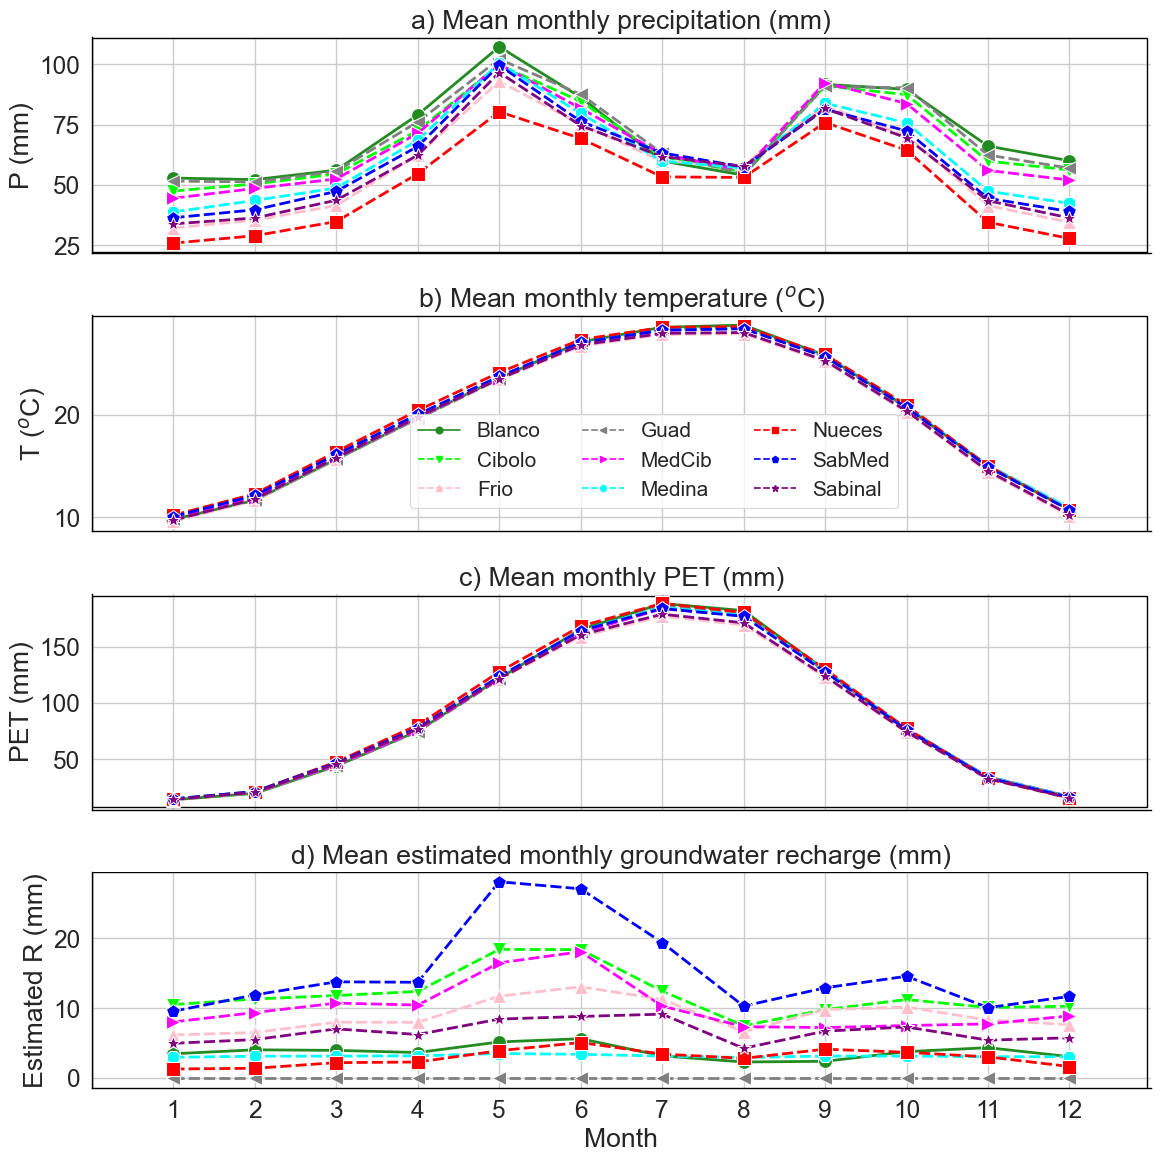

In [35]:
hue_colors = {'Blanco':'forestgreen', 'Cibolo':'lime', 'Frio':'pink', 
     'Guad':'gray', 'MedCib':'magenta', 'Medina':'cyan', 
 'Nueces':'red','SabMed':'blue', 'Sabinal':'purple'}
filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*' )#, 'h')#, 'H', 'D', 'd', 'P', 'X')
row_order = ['prec', 'tmean', 'pet','groundwater recharge']

dash_styles = ["",
               (4, 1.5),
               (4, 1.5),
               (4, 1.5),
               (4, 1.5),
               (4, 1.5),
               (4, 1.5),
               (4, 1.5),
                 (4, 1.5)] #,    (4, 1.5), ]
fig3df=prismdf_monthly_plot.groupby(['variable','basin','zone','month']).mean().reset_index()
fig3dfnew=fig3df[(fig3df['variable']!='tmin') & (fig3df['variable']!='tmax')]
g = sns.relplot(x="month", y="value",lw=2,kind='line',markersize=10,markers=filled_markers,
                hue="basin", style='basin',row="variable",row_order= row_order, col='zone',palette=hue_colors,dashes=dash_styles,
                data=fig3dfnew[fig3dfnew['zone']=='Recharge'],facet_kws=dict(sharey=False),legend='brief',
                height=3, aspect=4.);

g.axes[3,0].set_ylabel('Estimated R (mm)')
g.axes[2,0].set_ylabel('PET (mm)')
g.axes[0,0].set_ylabel('P (mm)')
g.axes[1,0].set_ylabel('T ($^o$C)')
#g.axes[1,0].set_ylim(20,120)

g.axes[0,0].set_title('a) Mean monthly precipitation (mm)')
g.axes[1,0].set_title('b) Mean monthly temperature ($^o$C)')
g.axes[2,0].set_title('c) Mean monthly PET (mm)')
g.axes[3,0].set_title('d) Mean estimated monthly groundwater recharge (mm)')
g.axes[3,0].set_xlabel('Month')

g.axes[3,0].set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
g.axes[3,0].set_xlim(0,13)
#g.axes[2,0].set_ylim(10,30)
#for i in range(3):
#    g.axes[i,0].patch.set_edgecolor('black')

g.axes[0,0].add_patch(Rectangle((0, 22), 12.95,89, fill=False, edgecolor='black', lw=1))

g.axes[1,0].add_patch(Rectangle((0, 8), 12.95,21.6, fill=False, edgecolor='black', lw=1))

g.axes[2,0].add_patch(Rectangle((0, 8), 12.95,187, fill=False, edgecolor='black', lw=1))

g.axes[3,0].add_patch(Rectangle((0, -2), 12.95,31.5, fill=False, edgecolor='black', lw=1))


h,l = g.axes[0,0].get_legend_handles_labels()
g._legend.remove()
g.fig.legend(h,l, bbox_to_anchor=[0.5, .6], 
           loc='center', ncol=3,fontsize=15)


plt.savefig(os.path.join(pathoutput,'Figure 2 mean monthly groundwater recharge precipitation and temperature.eps'), format='eps',dpi=600)    

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


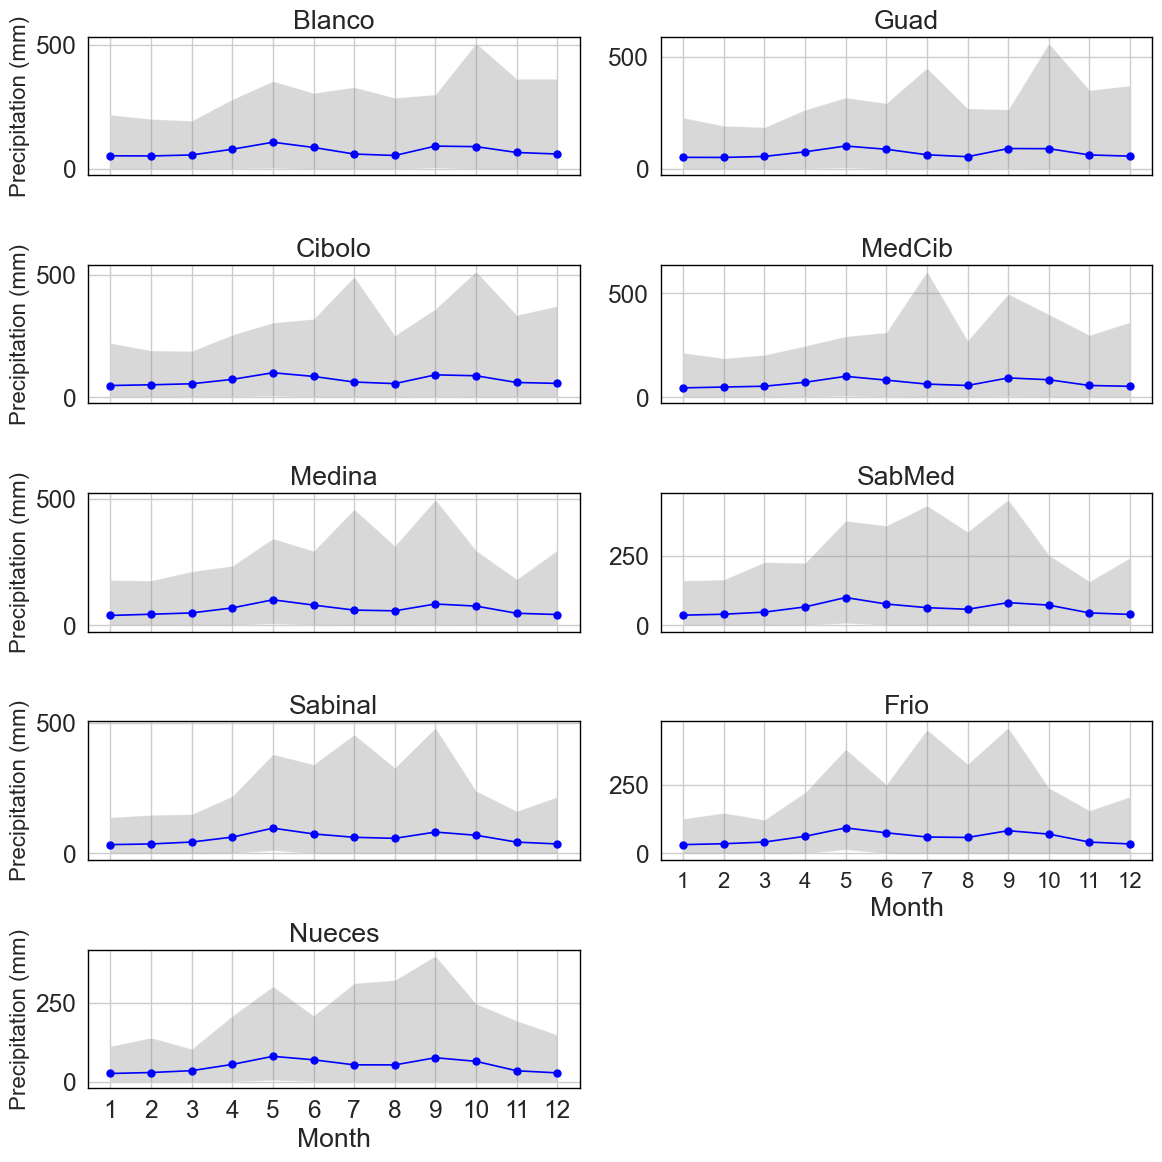

In [36]:
## For precipitation
fig, ax = plt.subplots(5,2,figsize=(12,12),sharex=True)
basinOrder = ['Blanco', 'Guad','Cibolo', 'MedCib', 'Medina',
       'SabMed', 'Sabinal','Frio', 'Nueces']
pptDF = prismdf_monthly_plot[prismdf_monthly_plot['variable']=='prec']

for idx, basin in enumerate(basinOrder):
    df = pptDF[pptDF['basin']==basin]
    tsMean= df.groupby(by=['month']).mean()
    tsMin = df.groupby(by=['month']).min()
    tsMax = df.groupby(by=['month']).max()
    i = idx // 2
    j = idx % 2
    x = [str(x) for x in tsMean.index]
    ax[i,j].plot(x,tsMean['value'],'b-o',markersize=5)
    ax[i,j].fill_between(x, tsMin['value'],tsMax['value'],alpha=0.3,facecolor='grey')
    ax[i,j].set_title(basin)
    if j==0:
        ax[i,j].set_ylabel('Precipitation (mm)',fontsize=16)
#ax[3,1].tick_params(axis='both', which='both', labelsize=16)   
ax[3,1].xaxis.set_tick_params(labelbottom=True,labelsize=16)
ax[4,0].set_xlabel('Month')
ax[3,1].set_xlabel('Month')

fig.delaxes(ax[4][1])    

plt.tight_layout()
plt.savefig(os.path.join(pathoutput,'New Sppl Figure 2 range of monthly precipitation.eps'), format='eps',dpi=600)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


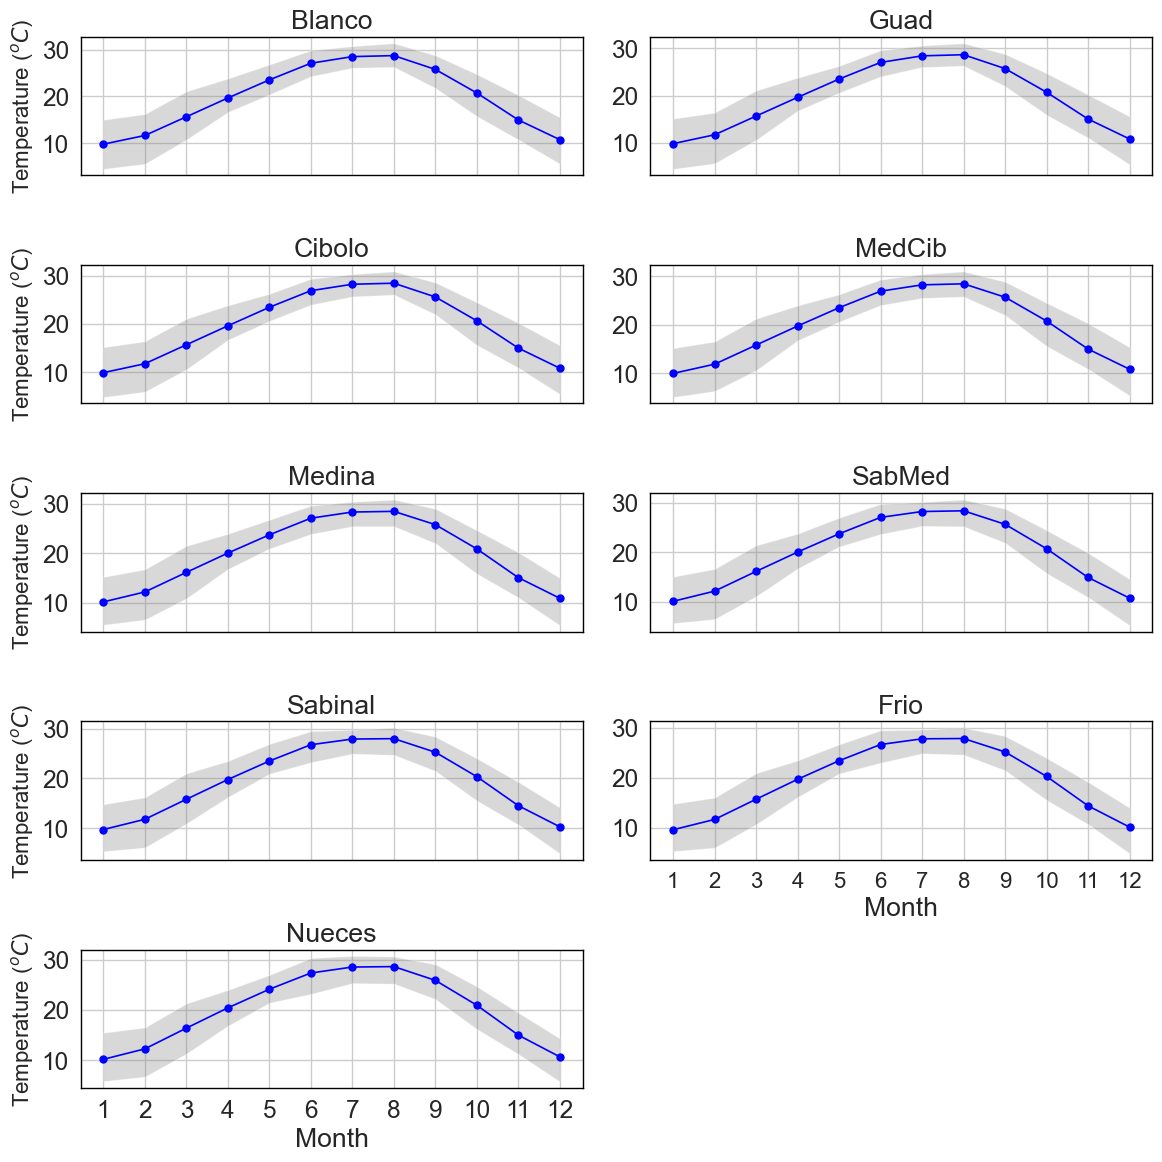

In [37]:
fig, ax = plt.subplots(5,2,figsize=(12,12),sharex=True)
basinOrder = ['Blanco', 'Guad','Cibolo', 'MedCib', 'Medina',
       'SabMed', 'Sabinal','Frio', 'Nueces']
TmeanDF = prismdf_monthly_plot[prismdf_monthly_plot['variable']=='tmean']

for idx, basin in enumerate(basinOrder):
    df = TmeanDF[TmeanDF['basin']==basin]
    tsMean= df.groupby(by=['month']).mean()
    tsMin = df.groupby(by=['month']).min()
    tsMax = df.groupby(by=['month']).max()
    i = idx // 2
    j = idx % 2
    x = [str(x) for x in tsMean.index]
    ax[i,j].plot(x,tsMean['value'],'b-o',markersize=5)
    ax[i,j].fill_between(x, tsMin['value'],tsMax['value'],alpha=0.3,facecolor='grey')
    ax[i,j].set_title(basin)
    if j==0:
        ax[i,j].set_ylabel('Temperature ($^oC$)',fontsize=16)
#ax[3,1].tick_params(axis='both', which='both', labelsize=16)   
ax[3,1].xaxis.set_tick_params(labelbottom=True,labelsize=16)
ax[4,0].set_xlabel('Month')
ax[3,1].set_xlabel('Month')

fig.delaxes(ax[4][1])    

plt.tight_layout()
plt.savefig(os.path.join(pathoutput,'New Sppl Figure 2 range of monthly temperature.eps'), format='eps',dpi=600)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


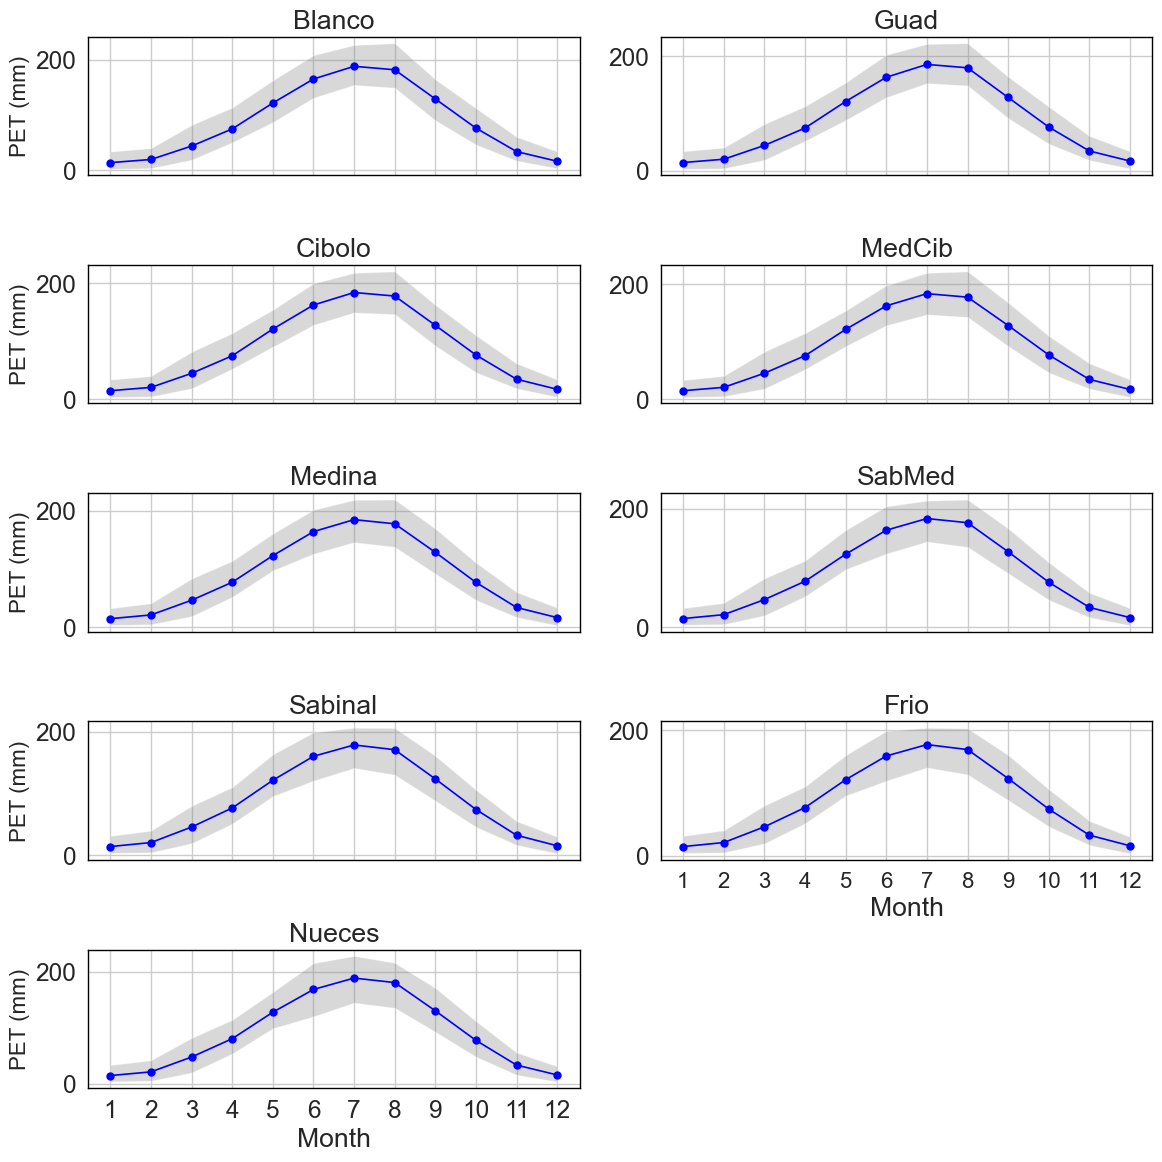

In [38]:
fig, ax = plt.subplots(5,2,figsize=(12,12),sharex=True)
basinOrder = ['Blanco', 'Guad','Cibolo', 'MedCib', 'Medina',
       'SabMed', 'Sabinal','Frio', 'Nueces']
petDF = prismdf_monthly_plot[prismdf_monthly_plot['variable']=='pet']

for idx, basin in enumerate(basinOrder):
    df = petDF[petDF['basin']==basin]
    tsMean= df.groupby(by=['month']).mean()
    tsMin = df.groupby(by=['month']).min()
    tsMax = df.groupby(by=['month']).max()
    i = idx // 2
    j = idx % 2
    x = [str(x) for x in tsMean.index]
    ax[i,j].plot(x,tsMean['value'],'b-o',markersize=5)
    ax[i,j].fill_between(x, tsMin['value'],tsMax['value'],alpha=0.3,facecolor='grey')
    ax[i,j].set_title(basin)
    if j==0:
        ax[i,j].set_ylabel('PET (mm)',fontsize=16)
#ax[3,1].tick_params(axis='both', which='both', labelsize=16)   
ax[3,1].xaxis.set_tick_params(labelbottom=True,labelsize=16)
ax[4,0].set_xlabel('Month')
ax[3,1].set_xlabel('Month')

fig.delaxes(ax[4][1])    

plt.tight_layout()
plt.savefig(os.path.join(pathoutput,'New Sppl Figure 2 range of monthly PET.eps'), format='eps',dpi=600)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


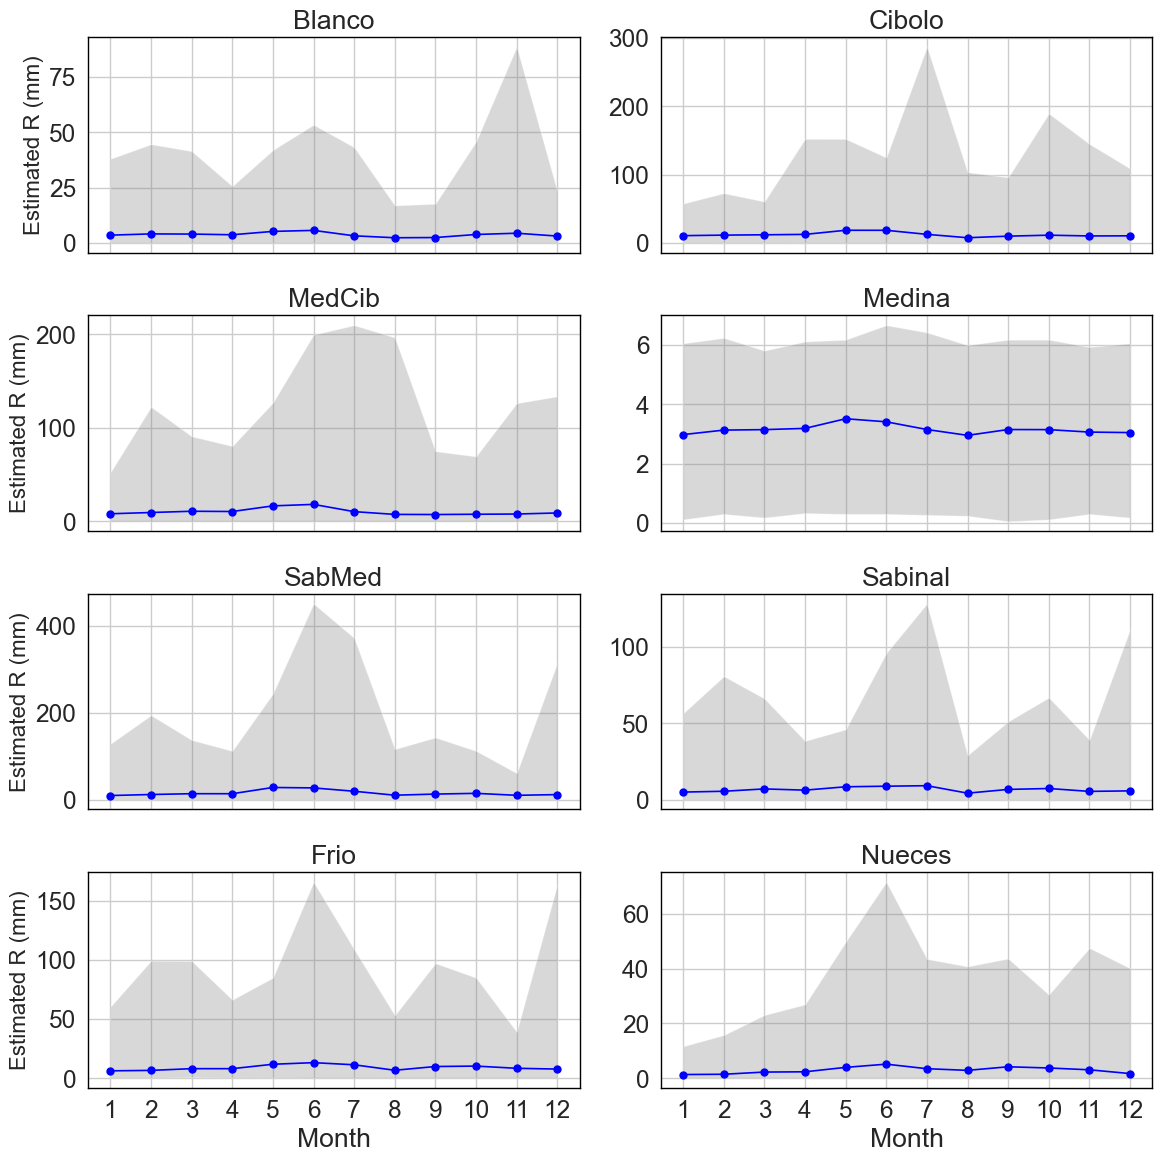

In [39]:
fig, ax = plt.subplots(4,2,figsize=(12,12),sharex=True)
basinOrder = ['Blanco', 'Cibolo', 'MedCib', 'Medina',
       'SabMed', 'Sabinal','Frio', 'Nueces']
gRDF = prismdf_monthly_plot[prismdf_monthly_plot['variable']=='groundwater recharge']
gRDF = gRDF[~gRDF['basin'].isin(['Guad'])]

for idx, basin in enumerate(basinOrder):
    df = gRDF[gRDF['basin']==basin]
    tsMean= df.groupby(by=['month']).mean()
    tsMin = df.groupby(by=['month']).min()
    tsMax = df.groupby(by=['month']).max()
    i = idx // 2
    j = idx % 2
    x = [str(x) for x in tsMean.index]
    ax[i,j].plot(x,tsMean['value'],'b-o',markersize=5)
    ax[i,j].fill_between(x, tsMin['value'],tsMax['value'],alpha=0.3,facecolor='grey')
    ax[i,j].set_title(basin)
    if j==0:
        ax[i,j].set_ylabel('Estimated R (mm)',fontsize=16)
ax[3,0].set_xlabel('Month')
ax[3,1].set_xlabel('Month')

plt.tight_layout()
plt.savefig(os.path.join(pathoutput,'New Sppl Figure 2 range of monthly groundwater recharge.eps'), format='eps',dpi=600)

# Climate variability

In [40]:
#variables=fig4df.variables.unique()
vardf=df_yearly.copy()
tables=pd.pivot_table(vardf,values='value',columns=['variable','zone','basin'],index='date')
annual_rollingvaribility=tables.rolling(20).var()/tables.var()

### Figure 3

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


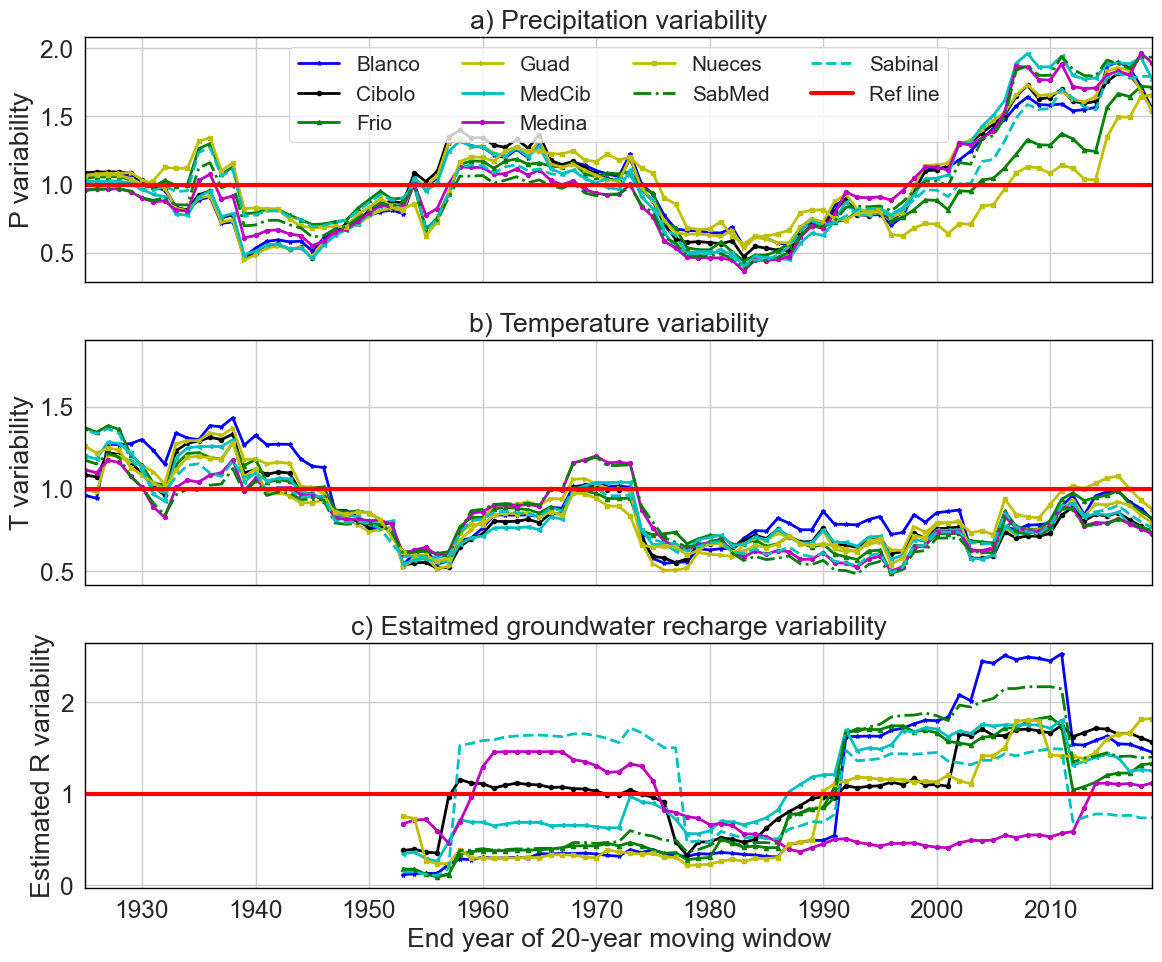

In [41]:

fig, ax=plt.subplots(3,1,figsize=(12,10),sharex=True)
styles=['b*-','ko-','g^-','y>-','c<-','m8-','ys-','g-.','c--']

one_df=pd.DataFrame({'year':annual_rollingvaribility.index,'Ref line':[1]*len(annual_rollingvaribility)})
one_df=one_df.set_index('year')

annual_rollingvaribility['groundwater recharge','Recharge'].plot(ax=ax[2],style=styles, linewidth=2.0,legend=False,markersize=3)
one_df.plot(ax=ax[2],style='r-', linewidth=3.0,legend=False,markersize=4)

ax[2].set_ylabel('Estimated R variability')
ax[2].set_title('c) Estaitmed groundwater recharge variability')
ax[2].set_xlabel('End year of 20-year moving window')

ax[2].grid(True)

annual_rollingvaribility['prec','Recharge'].plot(ax=ax[0],style=styles, linewidth=2.0,legend=False,markersize=3)
one_df.plot(ax=ax[0],style='r-', linewidth=3.0,legend=False,markersize=4)

ax[0].set_ylabel('P variability')
#ax[1].set_xlim('1925','2019')
ax[0].set_title('a) Precipitation variability')
ax[0].grid(True)
annual_rollingvaribility['tmean','Recharge'].plot(ax=ax[1],style=styles, linewidth=2.0,legend=False,markersize=3)
one_df.plot(ax=ax[1],style='r-', linewidth=3.0,legend=False,markersize=4)

ax[1].set_ylabel('T variability')
ax[1].set_xlim('1925','2019')
ax[1].set_title('b) Temperature variability')
ax[1].grid(True)

ax[0].legend(loc='best', ncol=4,fontsize=15)
#ax[2].set_title('e) Tmin variability')
ax[2].grid(True)
plt.tight_layout()
plt.savefig(os.path.join(pathoutput,'New Figure 3 Annual varaibility of a) precipitation, b) temperature, and c) groundwater recharge for the historical period.eps'), format='eps',dpi=600)
plt.savefig(os.path.join(pathoutput,'New Figure 3 Annual varaibility of a) precipitation, b) temperature, and c) groundwater recharge for the historical period.png'), format='png',dpi=600)

## Conduct elasticity analysis with the GLS bivariate approach

In [42]:
prismdf_monthly=pd.concat([prismprec_monthly,prismtmean_monthly,dfpet],axis=0)


In [43]:

annual_elas_GLS2=pd.DataFrame()
basins=list(usgsR_monthly['basin'].unique())
basins.remove('Guad')

for i,basin in enumerate(basins):
    df1=prismdf_monthly[(prismdf_monthly['basin']==basin) & (prismdf_monthly['zone']=='Recharge')] 
    df_Prec=df1[df1['variable']=='prec'].loc['1934-01':'2019-12','value'].resample('Y').sum() 
    df3=usgsR_monthly[usgsR_monthly['basin']==basin].loc['1934-01':'2019-12','value'].resample('Y').sum()      
    qmean=np.mean(df3.values)
    Precmean=np.mean(df_Prec)
    tsR=(df3.values-qmean)/qmean
    tsP=(df_Prec.values-Precmean)/Precmean
    df_tmean= df1[df1['variable']=='pet'].loc['1934-01':'2019-12','value'].resample('Y').sum() 
    Tmean=np.mean(df_tmean.values)
    tsT=(df_tmean.values-Tmean)/Tmean
    tsX=pd.DataFrame({'P':tsP,'PET':tsT})
    model=sm.GLS(tsR,tsX)
    results = model.fit()
    slope=results.params
    confi=results.conf_int(alpha=0.05)

    slope.name='slope' 
    confi.columns=['low','upper']
    resdf1=pd.concat([slope,confi],axis=1)
    resdf1['basin']=basin
    resdf1['R2']=[results.rsquared,results.rsquared]                                                                                               
    
    
    
    if len(annual_elas_GLS2)==0:
        annual_elas_GLS2=resdf1
    else:
        annual_elas_GLS2=pd.concat([annual_elas_GLS2,resdf1])
    
pdf=annual_elas_GLS2.loc['P']
pdf=pdf.reset_index()
tdf=annual_elas_GLS2.loc['PET']
tdf=tdf.reset_index()
annual_elas_GLS2f=pd.merge(pdf,tdf,on='basin',suffixes=('_GLS2_P','_GLS2_PET'))
annual_elas_GLS2f.to_csv(os.path.join(pathoutput,'Annual_elas_gls2_PET.csv') )
annual_elas_GLS2f


,index_GLS2_P,slope_GLS2_P,low_GLS2_P,upper_GLS2_P,basin,R2_GLS2_P,index_GLS2_PET,slope_GLS2_PET,low_GLS2_PET,upper_GLS2_PET,R2_GLS2_PET
0,P,2.124766,1.625411,2.624120,Nueces,0.526812,PET,0.897018,-2.212381,4.006417,0.526812
1,P,1.775356,1.273536,2.277177,Frio,0.544499,PET,-3.856200,-7.226113,-0.486288,0.544499
2,P,1.869234,1.269173,2.469295,Sabinal,0.506853,PET,-4.880831,-8.820920,-0.940742,0.506853
3,P,2.276409,1.784018,2.768799,SabMed,0.654237,PET,-3.869971,-6.855498,-0.884443,0.654237
4,P,0.407328,0.147259,0.667396,Medina,0.326570,PET,-2.697244,-4.291553,-1.102934,0.326570
5,P,2.016352,1.517668,2.515036,MedCib,0.563142,PET,-4.023964,-7.289021,-0.758908,0.563142
6,P,2.042581,1.562832,2.522330,Cibolo,0.543390,PET,-1.725694,-4.848053,1.396664,0.543390
7,P,1.753736,1.228246,2.279225,Blanco,0.424451,PET,-0.859245,-3.976024,2.257535,0.424451


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


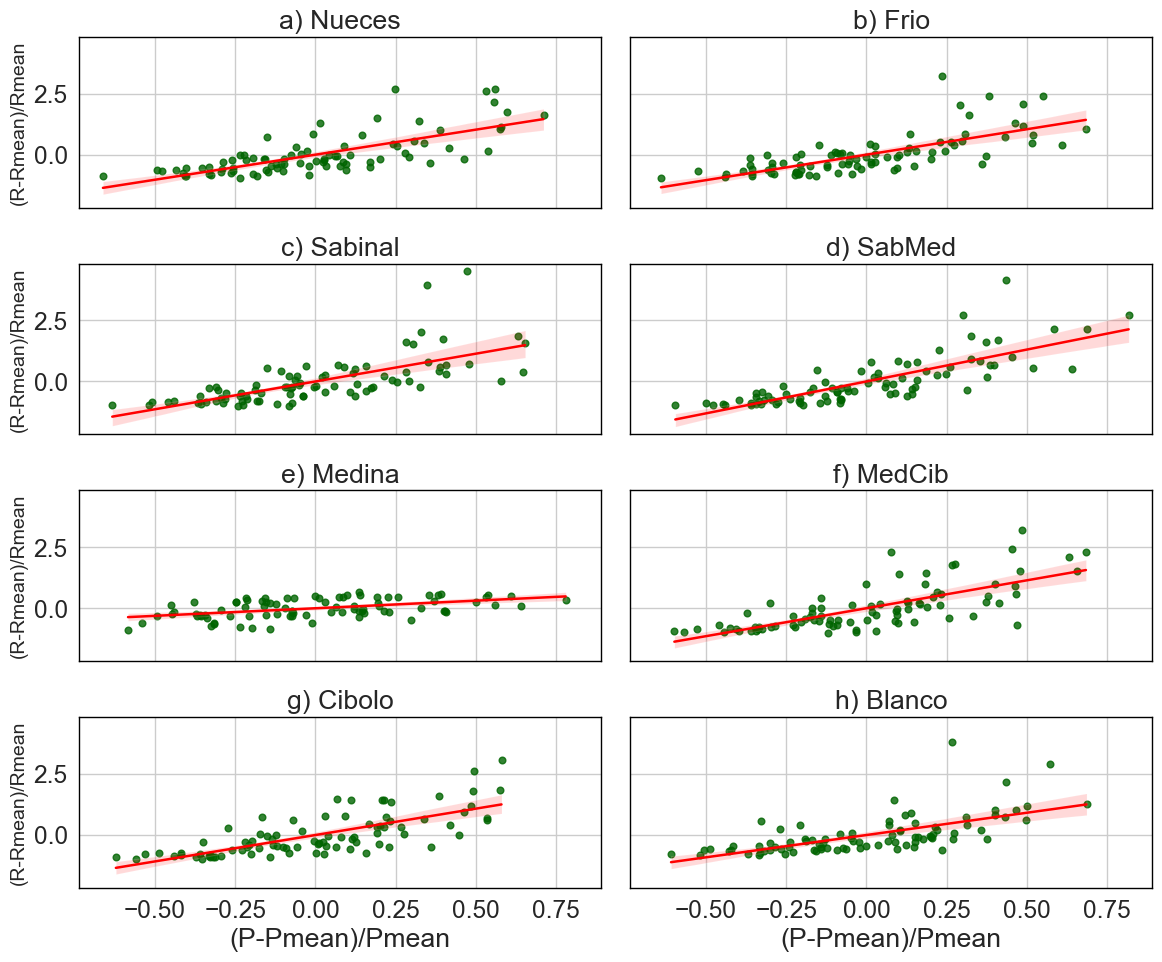

In [44]:
annual_elas=pd.DataFrame()
basins=list(usgsR_monthly['basin'].unique())
basins.remove('Guad')
m=['o','v','H','>','<','^','p','D']
color=['b','k','m','b','k','m','b','k']
alphTitles = ['a)','b)','c)','d)','e)','f)','g)','h)']
fig,ax=plt.subplots(4,2,figsize=(12,10),sharey=True,sharex=True)
for idx,basin in enumerate(basins):
    df1=prismdf_monthly[(prismdf_monthly['basin']==basin) & (prismdf_monthly['zone']=='Recharge')] 
    df_Prec=df1[df1['variable']=='prec'].loc['1934-01':'2019-12','value'].resample('Y').sum() 
    df3=usgsR_monthly[usgsR_monthly['basin']==basin].loc['1934-01':'2019-12','value'].resample('Y').sum()      
    qmean=np.mean(df3.values)
    Precmean=np.mean(df_Prec)
    i = idx // 2
    j = idx % 2
    tempDF = pd.DataFrame({'P':(df_Prec.values-Precmean)/Precmean,'Q':(df3.values-qmean)/qmean})
    g = sns.regplot(data = tempDF, y = 'Q',x='P',x_ci='ci',ci=95,scatter=True, fit_reg=True,ax=ax[i,j],
               marker = 'o',color='b',scatter_kws={"color": "darkgreen"}, line_kws={"color": "red"})                      
    ax[i,j].set_xlabel("")
    ax[i,j].set_ylabel("")
    
    ax[i,j].set_title(alphTitles[idx]+ " " + basin)
    if j==0:
        ax[i,j].set_ylabel('(R-Rmean)/Rmean',fontsize=14)
        
ax[3,0].set_xlabel('(P-Pmean)/Pmean')
ax[3,1].set_xlabel('(P-Pmean)/Pmean')

fig.tight_layout()
plt.savefig(os.path.join(pathoutput,'New figure 4 correlation of R to P.eps'), format='eps',dpi=600)
plt.savefig(os.path.join(pathoutput,'New figure 4 correlation of R to P.png'), format='png',dpi=600)
     

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


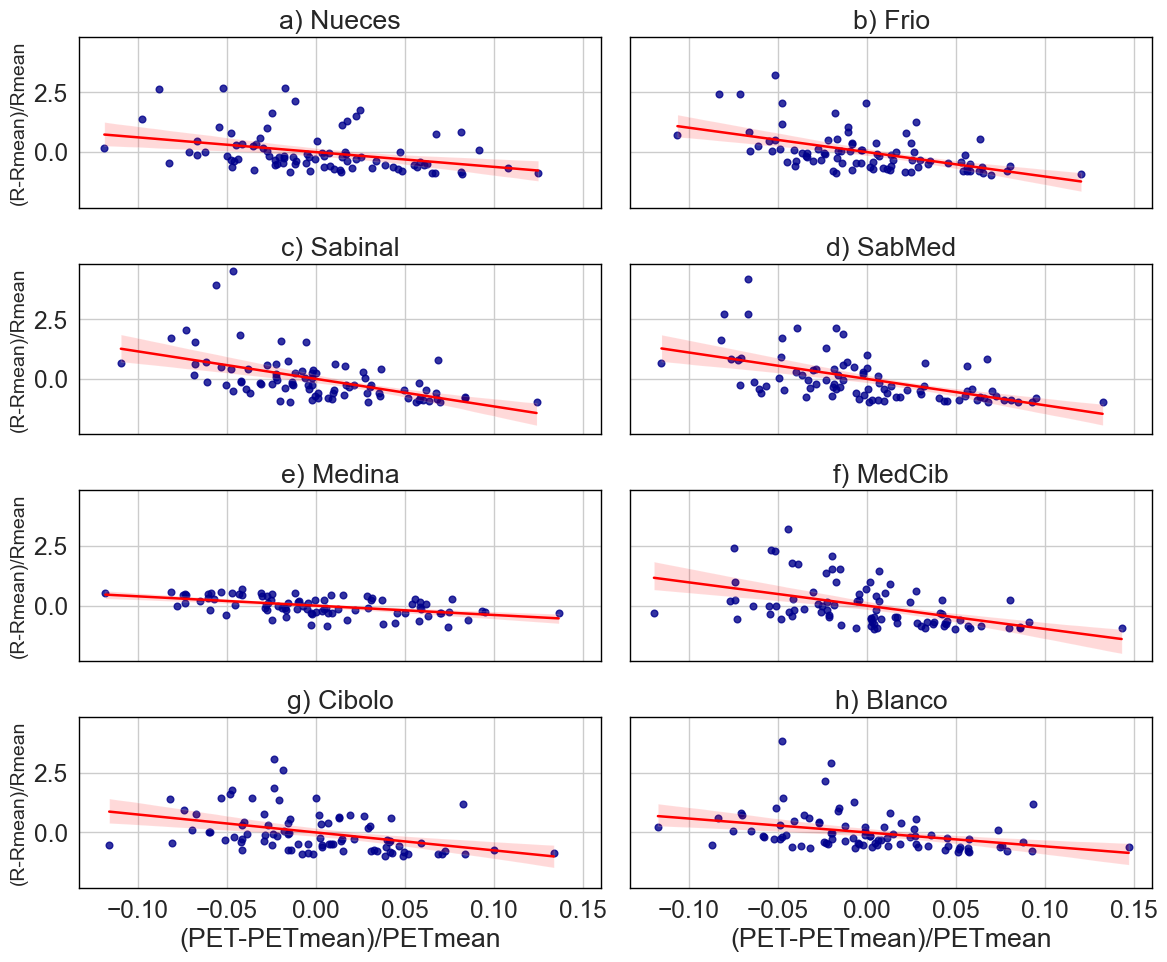

In [45]:
annual_elas=pd.DataFrame()
basins=list(usgsR_monthly['basin'].unique())
basins.remove('Guad')
m=['o','v','H','>','<','^','p','D']
color=['b','k','m','b','k','m','b','k']
alphTitles = ['a)','b)','c)','d)','e)','f)','g)','h)']

fig,ax=plt.subplots(4,2,figsize=(12,10),sharey=True,sharex=True)
for idx,basin in enumerate(basins):
    df1=prismdf_monthly[(prismdf_monthly['basin']==basin) & (prismdf_monthly['zone']=='Recharge')] 

    df_PET=df1[df1['variable']=='pet'].loc['1934-01':'2019-12','value'].resample('Y').sum() 
    df3=usgsR_monthly[usgsR_monthly['basin']==basin].loc['1934-01':'2019-12','value'].resample('Y').sum()      
    qmean=np.mean(df3.values)
    PETmean=np.mean(df_PET)
    
    i = idx // 2
    j = idx % 2
    tempDF = pd.DataFrame({'P':(df_PET.values-PETmean)/PETmean,'Q':(df3.values-qmean)/qmean})
    g = sns.regplot(data = tempDF, y = 'Q',x='P',x_ci='ci',ci=95,scatter=True, fit_reg=True,ax=ax[i,j],
               marker = 'o',color='b',scatter_kws={"color": "darkblue"}, line_kws={"color": "red"})                      
    ax[i,j].set_xlabel("")
    ax[i,j].set_ylabel("")
    
    ax[i,j].set_title(alphTitles[idx]+ " " + basin)
    
    if j==0:
        ax[i,j].set_ylabel('(R-Rmean)/Rmean',fontsize=14)
        
ax[3,0].set_xlabel('(PET-PETmean)/PETmean')
ax[3,1].set_xlabel('(PET-PETmean)/PETmean')

fig.tight_layout()
plt.savefig(os.path.join(pathoutput,'New figure 5 correlation of R to PET.eps'), format='eps',dpi=600)
plt.savefig(os.path.join(pathoutput,'New figure 5 correlation of R to PET.png'), format='png',dpi=600)
     

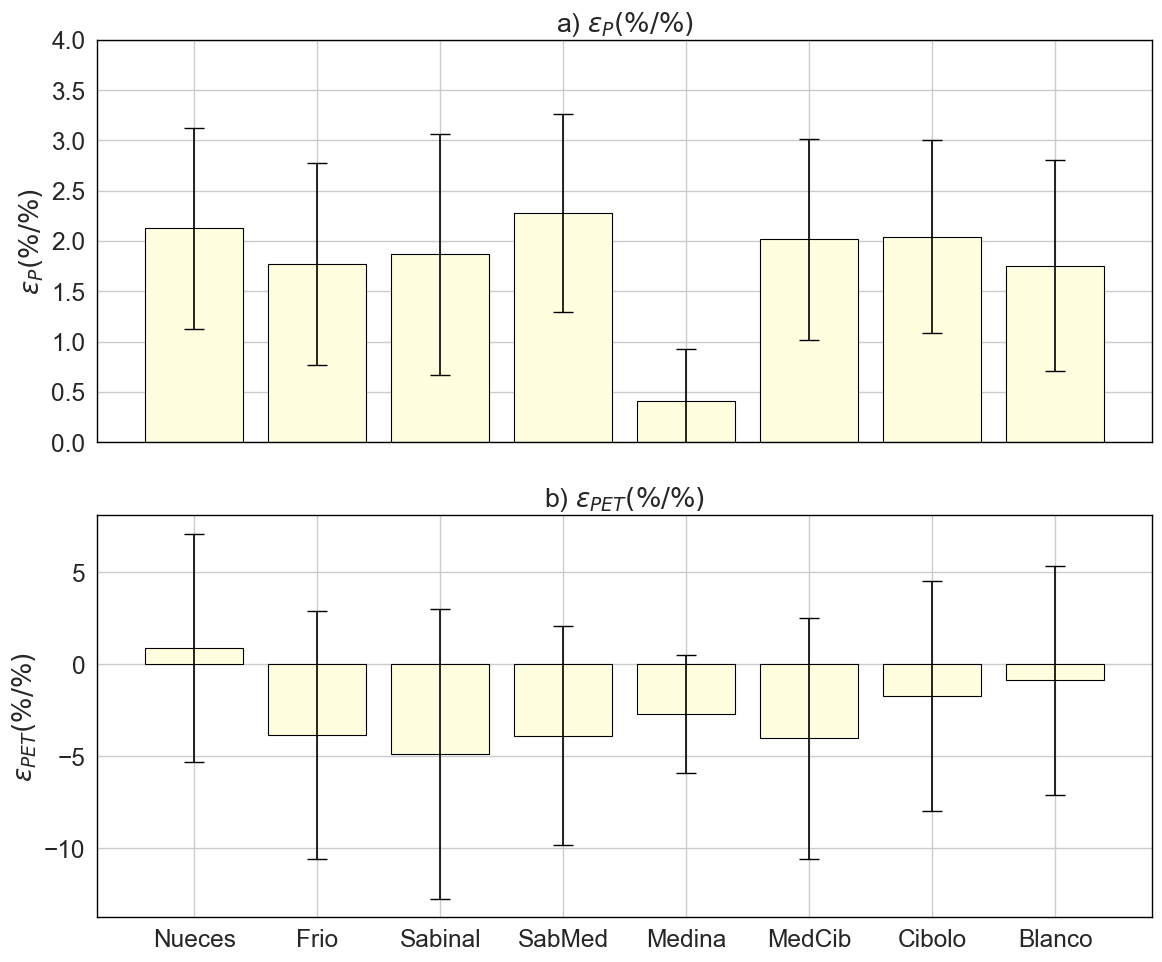

In [46]:
fig,ax=plt.subplots(2,1,figsize=(12,10),sharex=True)

### Precipitation elasticity
GLS2f=annual_elas_GLS2f.loc[:,['basin','slope_GLS2_P','low_GLS2_P','upper_GLS2_P']]
GLS2f=GLS2f.set_index('basin')
GLS2f['yerr']=GLS2f['upper_GLS2_P']-GLS2f['low_GLS2_P']
ax[0].bar(GLS2f.index,GLS2f['slope_GLS2_P'],yerr=GLS2f['yerr'],capsize=7,color = 'lightyellow', edgecolor = 'black')
ax[0].set_ylim(0,4)
ax[0].set_ylabel('$ε_P ( \%/\%)$')
ax[0].set_title('a) $ε_P ( \%/\%)$')

### PET elasticity
GLS2f_PET=annual_elas_GLS2f.loc[:,['basin','slope_GLS2_PET','low_GLS2_PET','upper_GLS2_PET']]
#nonpara=annual_elas.loc[:,['PET_elas_nonparam']]
GLS2f_PET=GLS2f_PET.set_index('basin')
GLS2f_PET['yerr']=GLS2f_PET['upper_GLS2_PET']-GLS2f_PET['low_GLS2_PET']
ax[1].bar(GLS2f_PET.index,GLS2f_PET['slope_GLS2_PET'],yerr=GLS2f_PET['yerr'],capsize=7,color = 'lightyellow', edgecolor = 'black')


ax[1].set_ylabel('$ε_{PET} ( \%/\%)$')
ax[1].set_title('b) $ε_{PET} ( \%/\%)$')

fig.tight_layout()

plt.savefig(os.path.join(pathoutput,'new figure 6 comparison_Annual_elasticity.eps'), format='eps',dpi=600)
plt.savefig(os.path.join(pathoutput,'new figure 6 comparison_Annual_elasticity.png'), format='png',dpi=600)